read and create train, properties and test datasets, sample_submission is used to create to generate csv file for 5 predictions 

In [1]:
import pandas as pd
import numpy as np
data_dir = '../input/'
props = pd.read_csv(data_dir + 'properties_2017.csv')
train_2016 = pd.read_csv(data_dir + 'train_2016_v2.csv')
train_2017 = pd.read_csv(data_dir + 'train_2017.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission = sample_submission.rename(columns={'ParcelId': 'parcelid'})
sample_submission2 = sample_submission.copy()
sample_submission3 = sample_submission.copy()
sample_submission4 = sample_submission.copy()
sample_submission5 = sample_submission.copy()


test_df = pd.read_csv("../input/sample_submission.csv")
test_df = test_df.rename(columns={'ParcelId': 'parcelid'})

C:\software_program\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


split transaction date into 3 sub-features, 'transactionyear', 'transactionmonth', 'transactionday'

In [2]:
train_2016[['transactionyear', 'transactionmonth', 'transactionday']] = train_2016['transactiondate'].str.split('-', expand=True)
train_2017[['transactionyear', 'transactionmonth', 'transactionday']] = train_2017['transactiondate'].str.split('-', expand=True)

Combine train2016 with train2017 to make a whole train datasets

In [3]:
train = pd.concat([train_2016, train_2017], ignore_index=True)

## Data preprocessing part

In [4]:
# Data preprocessing part

#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = props.hashottuborspa.isnull()
#print(index)
props.loc[index,'hashottuborspa'] = "FALSE"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field
print(props.hashottuborspa.value_counts())
print(props.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
# dropcols.append('pooltypeid10')

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = props.pooltypeid2.isnull()
props.loc[index,'pooltypeid2'] = 0

index = props.pooltypeid7.isnull()
props.loc[index,'pooltypeid7'] = 0

index = props.poolcnt.isnull()
props.loc[index,'poolcnt'] = 0

#Theres more missing values in the 'poolsizesum' then in 'poolcnt', 
#Let's fill in median values for poolsizesum where pool count is >0 and missing. 
#This is sensible assumption as residential pool sizes are fairly standard size in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable so imputing with the median
print(props.poolsizesum.isnull().sum())
print(props.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = props.loc[props['poolcnt'] > 0, 'poolsizesum'].median()
props.loc[(props['poolcnt'] > 0) & (props['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
props.loc[(props['poolcnt'] == 0), 'poolsizesum'] = 0

#There should be a one-to-one correspondence between these two items
print(props.fireplaceflag.isnull().sum())
print(props.fireplacecnt.isnull().sum())


#There seems to be 80668 properties without fireplace according to the 'fireplacecnt' but the 'fireplace flag' says they are 90053 missing values
#Lets instead create the fireplaceflag from scratch using 'fireplacecnt' as there are less missing values here
props['fireplaceflag']= "FALSE"
props.loc[props['fireplacecnt']>0,'fireplaceflag']= "TRUE"

index = props.fireplacecnt.isnull()
props.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = props.taxdelinquencyflag.isnull()
props.loc[index,'taxdelinquencyflag'] = "N"

#Same number of missing values between garage count and garage size - assume this is because when there are properties with no garages then both variables are NA
print(props.garagecarcnt.isnull().sum())
print(props.garagetotalsqft.isnull().sum())

#Assume if Null in garage count it means there are no garages
index = props.garagecarcnt.isnull()
props.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = props.garagetotalsqft.isnull()
props.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values using the most common value for those variables where this might be a sensible approach
#AC Type - Mostly 1's, which corresponds to central AC. Reasonable to assume most other properties are similar.
props['airconditioningtypeid'].value_counts()
index = props.airconditioningtypeid.isnull()
props.loc[index,'airconditioningtypeid'] = 1


#heating or system - Mostly 2, which corresponds to central heating 
#so seems reasonable to assume most other properties have central heating  
print(props['heatingorsystemtypeid'].value_counts())
index = props.heatingorsystemtypeid.isnull()
props.loc[index,'heatingorsystemtypeid'] = 2


print(props['threequarterbathnbr'].value_counts())
index = props.threequarterbathnbr.isnull()
props.loc[index,'threequarterbathnbr'] = 1


missingvalues_prop = (props.isnull().sum()/len(props)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.90].field.tolist()
#dropcols_2 = dropcols + missingvaluescols
#props = props.drop(dropcols_2, axis=1)
props = props.drop(missingvaluescols, axis=1)

FALSE    2935155
True       50062
Name: hashottuborspa, dtype: int64
1.0    17006
Name: pooltypeid10, dtype: int64
2957259
0.0    2445585
1.0     539632
Name: poolcnt, dtype: int64
2980054
2672093
2094209
2094209
2.0     1168610
7.0      646021
6.0       27481
24.0      21107
20.0       3630
13.0       1342
18.0        586
1.0         262
14.0         41
10.0         39
12.0         25
11.0         16
21.0          3
19.0          1
Name: heatingorsystemtypeid, dtype: int64
1.0    313464
2.0      2548
3.0       268
4.0        48
5.0        18
6.0         9
7.0         2
Name: threequarterbathnbr, dtype: int64
                           field  proportion
41                   storytypeid    0.999456
3                   basementsqft    0.999455
46            yardbuildingsqft26    0.999114
2       architecturalstyletypeid    0.997970
43        typeconstructiontypeid    0.997740
13          finishedsquarefeet13    0.997430
6            buildingclasstypeid    0.995735
29                  poo

## Feature selection Part

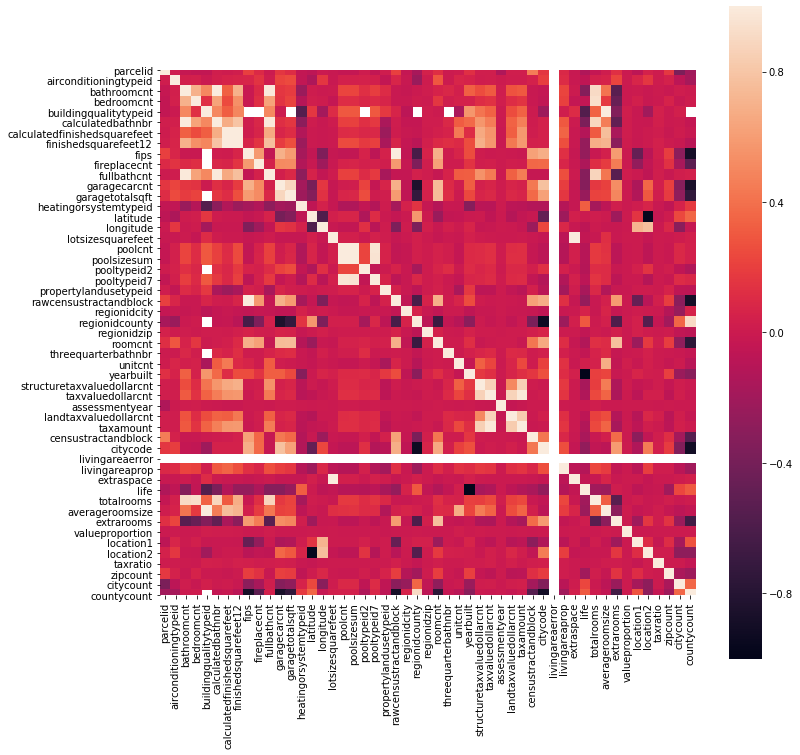

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

count = props.isnull().sum()
ratio = count / len(props)
null_data = pd.concat([count,ratio],axis=1,keys=['count','ratio'])
null_data


index = []
for i, v in enumerate(ratio):
    if v > 0.5:
        index.append(i)
        
props.drop(props.columns[index], axis = 1, inplace=True)        

correlation = props.corr()
plt.subplots(figsize=(12, 12))
sns.heatmap(correlation, square=True)
plt.show()


props['citycode'] = props['propertycountylandusecode'].apply(lambda x: str(x)[0:3])
lbl = LabelEncoder()
lbl.fit(list(props['citycode'].values))
props['citycode'] = lbl.transform(list(props['citycode'].values))

props['livingareaerror'] = props['calculatedfinishedsquarefeet'] / props['finishedsquarefeet12']

props['livingareaprop'] = props['calculatedfinishedsquarefeet'] / props['lotsizesquarefeet']

props['extraspace'] = props['lotsizesquarefeet'] - props['calculatedfinishedsquarefeet']

props['life'] = 2019 - props['yearbuilt']

props['totalrooms'] = props['bathroomcnt'] + props['bedroomcnt']

props['averageroomsize'] = props['calculatedfinishedsquarefeet'] / props['roomcnt']

props['extrarooms'] = props['roomcnt'] - props['totalrooms']

props['valueproportion'] = props['structuretaxvaluedollarcnt'] / props['landtaxvaluedollarcnt']

props["location1"] = props["latitude"] + props["longitude"]

props["location2"] = props["latitude"] * props["longitude"]

props['taxratio'] = props['taxvaluedollarcnt'] / props['taxamount']

zip_count = props['regionidzip'].value_counts().to_dict()
props['zipcount'] = props['regionidzip'].map(zip_count)

city_count = props['regionidcity'].value_counts().to_dict()
props['citycount'] = props['regionidcity'].map(city_count)

region_count = props['regionidcounty'].value_counts().to_dict()
props['countycount'] = props['regionidcounty'].map(region_count)

Combine props and train and test datasets so we can get train datasets which include all features,test dataset should drop 6 columns for there are no these features in train dataset

In [6]:
train_df = props.merge(train, how = 'left', on = 'parcelid') # get a complete dataframe
test_df = props.merge(test_df, on='parcelid', how='left')
test_df = test_df.drop(['201610', '201611', '201612', '201710', '201711', '201712'], axis = 1)

get the outlier range

In [7]:
# get outlier of logerror
ulimit = np.percentile(train.logerror.values, 99)  
print(ulimit)
llimit = np.percentile(train.logerror.values, 1)
print(llimit)

0.4959
-0.33113825441859


filter the data which logerror is between the valuable data range and drop some useless feature for train dataset and test dataset

In [10]:

train_df = train_df[train_df.logerror > -0.33113825441859]
train_df = train_df[train_df.logerror <0.4959]
do_not_include = ['parcelid', 'logerror', 'transactiondate','transactionday']
feature_names = [f for f in train_df.columns if f not in do_not_include]

X_train = train_df[feature_names].copy()
y_train = train_df.logerror
test_df = test_df.drop(['parcelid'] ,axis = 1)



Find the feature name where the feature variable is a categorical variable

In [11]:
# get the data index which is categorical 
s = (X_train.dtypes =='object')
object_cols = list(s[s].index)

Numerically represent the categorical variables for our train dataset and test dataset so that our model can be trained. 
Represent the remaining nan value with -1

In [ ]:
from sklearn.preprocessing import LabelEncoder


# use labelencoder to encoder X_train and test data
label_X_train = X_train.copy()


for col in label_X_train.columns:
    label_X_train[col] = label_X_train[col].fillna(-1)
    if label_X_train[col].dtype =='object':
        lbl = LabelEncoder()
        lbl.fit(list(label_X_train[col].values))
        label_X_train[col] = lbl.transform(list(label_X_train[col].values))
for col in test_df.columns:
    test_df[col] = test_df[col].fillna(-1)
    if  test_df[col].dtype == 'object':
        lbl.fit(list(test_df[col].values))
        test_df[col] = lbl.transform(list(test_df[col].values))

    


The following feature names have been created as new features in the above process, so these features can be deleted because their feature information has been included in the newly generated feature.If the feature manufacturing part is not running, then the code in the following part needs to be commented out

In [ ]:
used_features = ['calculatedfinishedsquarefeet','finishedsquarefeet12',
               'lotsizesquarefeet','yearbuilt','bathroomcnt','bedroomcnt'
               ,'totalrooms','structuretaxvaluedollarcnt','landtaxvaluedollarcnt'
               ,"latitude", "longitude",'taxvaluedollarcnt','taxamount','regionidcounty'
                ,'regionidcity','regionidzip', 
               'averageroomsize']
label_X_train_sf = label_X_train.drop(used_features ,axis = 1)

If the feature manufacturing part is not running, then run the following line of code

In [ ]:
# label_X_train_sf = label_X_train.copy()

Add two columns of features to 6 test datasets, transactionyear and transactioinmonth, if you don't run the feature manufacturing part, you need to comment out drop used_features

In [ ]:


test_201610 = test_df.copy()
test_201610['transactionyear'] = 2016
test_201610['transactionmonth'] = 10
test_201610 = test_201610.drop(used_features ,axis = 1)

test_201611 = test_df.copy()
test_201611['transactionyear'] = 2016
test_201611['transactionmonth'] = 11
test_201611 = test_201611.drop(used_features ,axis = 1)

test_201612 = test_df.copy()
test_201612['transactionyear'] = 2016
test_201612['transactionmonth'] = 12
test_201612 = test_201612.drop(used_features ,axis = 1)

test_201710 = test_df.copy()
test_201710['transactionyear'] = 2017
test_201710['transactionmonth'] = 10
test_201710 = test_201710.drop(used_features ,axis = 1)

test_201711 = test_df.copy()
test_201711['transactionyear'] = 2017
test_201711['transactionmonth'] = 11
test_201711 = test_201711.drop(used_features ,axis = 1)

test_201712 = test_df.copy()
test_201712['transactionyear'] = 2017
test_201712['transactionmonth'] = 12
test_201712 = test_201712.drop(used_features ,axis = 1)



The following part is to reduce the dimension of the data. If you don’t want to reduce the dimension, you don't need  to run the code

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 8)
pca = pca.fit(label_X_train_sf)

label_x_train_sf = pca.transform(label_X_train_sf)
test_201610 = pca.transform(test_201610)
test_201611 = pca.transform(test_201611)
test_201612 = pca.transform(test_201612)
test_201710 = pca.transform(test_201710)
test_201711 = pca.transform(test_201711)
test_201712 = pca.transform(test_201712)

The following part is data standardization, you can skip if not running

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
label_X_train_sf = scaler.fit_transform(label_X_train_sf)
test_201610 = scaler.fit_transform(test_201610)
test_201611 = scaler.fit_transform(test_201611)
test_201612 = scaler.fit_transform(test_201612)
test_201710 = scaler.fit_transform(test_201710)
test_201711 = scaler.fit_transform(test_201711)
test_201712 = scaler.fit_transform(test_201712)

Free useless variable memory

In [ ]:
import gc

del label_X_train,X_train, train_df, test_df,props, train_2016, train_2017 ; gc.collect()

## XGBoost

### Parameter Tuning 
Use the grid search to get the best combination of parameters, the best results have been obtained, and the running time is extremely long.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

parameters = {"n_estimators": np.arange(200,500,50)
             , "learning_rate": np.arange(0.006, 0.02, 0.002)
             , "max_depth": np.arange(6,9,1)
             , "gamma": np.arange(0.5,2,0.3)
             , "reg_lambda": np.arange(0.5,2, 0.3)
             , "early_stopping_rounds": np.arange(5, 20, 2)
              ,"reg_alpha": np.arange(0.5, 2, 0.2)
             }

reg =  XGBRegressor(n_estimators = 450
                          , early_stopping_rounds = 5
                           , learning_rate = 0.014 
                           , max_depth = 6
                           , objective='reg:squarederror'
                          # , subsample = 0.7
                          #, reg_alpha = 0.9
                          , reg_lambda = 1.4
                         , gamma = 0.5)
GS = GridSearchCV(reg, parameters, cv=3)
GS.fit(label_X_train_sf, y_train)
GS.best_params_

 

Use XGBoost algorithm for training

In [ ]:
from xgboost import XGBRegressor

XGB_model_2 = XGBRegressor( n_estimators = 450
                         , early_stopping_rounds = 5
                         , learning_rate = 0.014
                         , max_depth = 5
                         , objective='reg:squarederror'
                         , reg_alpha = 0.7
                         , reg_lambda = 1.4
                         , gamma = 0.5
                          )

XGB_model_2.fit(label_X_train_sf, y_train)


Generate submission file and convert it to csv file

In [ ]:
sample_submission['201610'] = XGB_model_2.predict(test_201610)
sample_submission['201611'] = XGB_model_2.predict(test_201611)
sample_submission['201612'] = XGB_model_2.predict(test_201612)
sample_submission['201710'] = XGB_model_2.predict(test_201710)
sample_submission['201711'] = XGB_model_2.predict(test_201711)
sample_submission['201712'] = XGB_model_2.predict(test_201712)
sample_submission.to_csv(data_dir + 'XGB_output.csv', index = False)

## LightGBM part

### Parameter Tuning

In [ ]:
from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import KFold
no_fold = 4

# def objective_fun(boosting_type, num_leaves, max_depth, learning_rate, n_estimators, \
#                   min_split_gain, min_child_weight, min_child_samples, subsample, subsample_freq, \
#                   subsample_freq, colsample_bytree, reg_alpha, reg_lambda, random_state):
#     model = LGBMRegressor(boosting_type, num_leaves, max_depth, learning_rate, n_estimators, \
#                   min_split_gain, min_child_weight, min_child_samples, \
#                   subsample_freq, colsample_bytree, reg_alpha, reg_lambda, random_state)
def objective_fun(args):
#     boosting_type, num_leaves, max_depth, learning_rate, n_estimators, min_split_gain, min_child_weight, \
#     min_child_samples, subsample, subsample_freq, colsample_bytree, reg_alpha, reg_lambda, random_state = args
#     model = LGBMRegressor(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth, \
#                           learning_rate=learning_rate, n_estimators=n_estimators, \
#                           min_split_gain=min_split_gain, min_child_weight=min_child_weight, \
#                           min_child_samples=min_child_samples, subsample_freq, \
#                           subsample_freq=subsample_freq, colsample_bytree=colsample_bytree, \
#                           reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state)
    model = LGBMRegressor(num_leaves=int(args['num_leaves']), \
                          max_depth=int(args['max_depth']), learning_rate=args['learning_rate'], \
                          n_estimators=int(args['n_estimators']), min_split_gain=args['min_split_gain'], \
                          min_child_weight=args['min_child_weight'], min_child_samples=int(args['min_child_samples']), \
                          subsample=args['subsample'], subsample_freq=int(args['subsample_freq']), \
                          colsample_bytree=args['colsample_bytree'], reg_alpha=args['reg_alpha'], \
                          reg_lambda=args['reg_lambda'], random_state=args['random_state'])
    kf = KFold(n_splits=no_fold)
    loss = 0
    for index_tr, index_val in kf.split(training_data[features], training_data['logerror']):
        data_tr = training_data.iloc[index_tr]
        data_val = training_data.iloc[index_val]
        model.fit(data_tr[features], data_tr['logerror'])
        prediction = model.predict(data_val[features])
        loss += metrics.mean_absolute_error(data_val['logerror'], prediction) / no_fold
    return {
        'status' : 'ok',
        'loss' : loss
    }

hp_space = {
#    'boosting_type' : hp.choice('boosting_type', ['gbdt', 'dart', 'goss', 'rf']),
    'num_leaves' : hp.quniform('num_leaves', 10, 500, 1),
    'max_depth' : hp.quniform('max_depth', 10, 500, 1),
    'learning_rate' : hp.uniform('learning_rate', 0.0001, 0.1),
    'n_estimators' : hp.quniform('n_estimators', 10, 1000, 1),
    'min_split_gain' : hp.uniform('min_split_gain', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0.0001, 1),
    'min_child_samples' : hp.quniform('min_child_samples', 10, 500, 1),
    'subsample' : hp.uniform('subsample', 0, 1),
    'subsample_freq' : hp.quniform('subsample_freq', 0, 5000, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
    'random_state' :  None
}

trials = Trials()

best = fmin(fn=objective_fun, space=hp_space, algo=tpe.suggest, max_evals=1000, trials=trials)

import pickle
with open('trials', 'wb') as file:
    pickle.dump(best, file)
    pickle.dump(trials, file)

get best hyperparameters combination 

In [ ]:
best ={'colsample_bytree': 0.2147467656099759,
 'learning_rate': 0.007138343861070687,
 'max_depth': 442.0,
 'min_child_samples': 23.0,
 'min_child_weight': 0.8464143518606242,
 'min_split_gain': 0.000172647682586337,
 'n_estimators': 149.0,
 'num_leaves': 188.0,
 'reg_alpha': 2.6763347204500403,
 'reg_lambda': 2.5674135399163243,
 'subsample': 0.9996855816069476,
 'subsample_freq': 2629.0}

use LightGBM to train model

In [ ]:
from lightgbm import LGBMRegressor


LGB_model_1 = LGBMRegressor(colsample_bytree=best['colsample_bytree'], learning_rate=best['learning_rate'], \
                            max_depth=int(best['max_depth']), min_child_samples=int(best['min_child_samples']), \
                            min_child_weight=best['min_child_weight'], min_split_gain=best['min_split_gain'], \
                            n_estimators=int(best['n_estimators']), num_leaves=int(best['num_leaves']), \
                            reg_alpha=best['reg_alpha'], reg_lambda=best['reg_lambda'], \
                            subsample=best['subsample'], subsample_freq=int(best['subsample_freq']))
LGB_model_1.fit(label_X_train_sf, y_train)


Generate submission file and convert it to csv file

In [ ]:
sample_submission2['201610'] = LGB_model_1.predict(test_201610)
sample_submission2['201611'] = LGB_model_1.predict(test_201611)
sample_submission2['201612'] = LGB_model_1.predict(test_201612)
sample_submission2['201710'] = LGB_model_1.predict(test_201710)
sample_submission2['201711'] = LGB_model_1.predict(test_201711)
sample_submission2['201712'] = LGB_model_1.predict(test_201712)
sample_submission2.to_csv(data_dir + 'LGB_output.csv', index = False)

## Lasso Part
### Parameter Tuning

adjust alpha automatically

In [ ]:

from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
lasso = Lasso(alpha = 1,max_iter = 10000)
# adjust alpha automatically
#lasso = LassoCV()
#lasso = LassoLarsCV()
lasso.fit(label_X_train_sf,y_train)
print("lasso regression model:",lasso)




Generate submission file and convert it to csv file

In [ ]:
sample_submission3['201610'] = lasso.predict(test_201610)
sample_submission3['201611'] = lasso.predict(test_201611)
sample_submission3['201612'] = lasso.predict(test_201612)
sample_submission3['201710'] = lasso.predict(test_201710)
sample_submission3['201711'] = lasso.predict(test_201711)
sample_submission3['201712'] = lasso.predict(test_201712)
sample_submission3.to_csv(data_dir + 'lasso_output.csv', index = False)

## Random Forest
## Parameter Tuning
Use the grid search to get the best combination of parameters, the best results have been obtained, and the running time is extremely long.

In [ ]:
GridSearchCV to find better parametres
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = { "n_estimators": [20,30,40], 
               "max_depth": [90,100,110],
               "max_features": [4,5,6,7]
             }
rf_draft = RandomForestRegressor(n_estimators=30,max_depth=100,random_state=42,max_features=5)
GS = GridSearchCV(rf_draft, parameters, cv=3)
GS.fit(label_X_train_sf, y_train)
GS.best_params_


{'max_depth': 90, 'max_features': 4, 'n_estimators': 40}

Use Random Forest to train and make prediction 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=40,max_depth=90,random_state=42,max_features=4)#,criterion='mae')
rf.fit(label_X_train_sf, y_train)

Generate submission file and convert it to csv file

In [ ]:
sample_submission4['201610'] = rf.predict(test_201610)
sample_submission4['201611'] = rf.predict(test_201611)
sample_submission4['201612'] = rf.predict(test_201612)
sample_submission4['201710'] = rf.predict(test_201710)
sample_submission4['201711'] = rf.predict(test_201711)
sample_submission4['201712'] = rf.predict(test_201712)
sample_submission4.to_csv(data_dir + 'random_forest_output.csv', index = False)

In [ ]:
xgb_ratio = 0.4
lgb_ratio = 0.3
lasso_ratio = 0.3


Generate combination algorithm prediction based on XGBoost and lightGBM and lasso

In [ ]:

sample_submission5['201610'] = xgb_ratio * sample_submission['201610']+lgb_ratio * sample_submission2['201610']+lasso_ratio * sample_submission3['201610']  
sample_submission5['201611'] = xgb_ratio * sample_submission['201611']+lgb_ratio * sample_submission2['201611']+lasso_ratio * sample_submission3['201611']  
sample_submission5['201612'] = xgb_ratio * sample_submission['201612']+lgb_ratio * sample_submission2['201612']+lasso_ratio * sample_submission3['201612']  
sample_submission5['201710'] = xgb_ratio * sample_submission['201710']+lgb_ratio * sample_submission2['201710']+lasso_ratio * sample_submission3['201710'] 
sample_submission5['201711'] = xgb_ratio * sample_submission['201711']+lgb_ratio * sample_submission2['201711']+lasso_ratio * sample_submission3['201711']  
sample_submission5['201712'] = xgb_ratio * sample_submission['201712']+lgb_ratio * sample_submission2['201712']+lasso_ratio * sample_submission3['201712'] 
sample_submission5.to_csv(data_dir + 'combination_output_withoutRF.csv', index = False)